# EIT2018 Fall detection based on Neural Network `V2.0`

Author: `Boyang Wang`                  

Date: `March 11 2018`

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
from shutil import copyfile
from tensorflow.contrib.tensorboard.plugins import projector
print ("PACKAGES LOADED")

PACKAGES LOADED


## Load data from `training_input.mat` for fall detection

 - training_input (12318,315)
 - traininig_label (12318,2)

In [2]:
cwd = os.getcwd()
org_data = loadmat(cwd+'/dataset/training_data_fixed.mat')

training_in = org_data['training_input']
training_out = org_data['training_output']

train_input = training_in[0:6000,:]
train_label = training_out[0:6000,:]
train_validate = training_in[6000:,:]
train_validate_label = training_out[6000:,:]

#print(train_input.shape)
#print(train_lable.shape)
print(train_validate.shape)
print(train_validate_label.shape)

(2150, 270)
(2150, 2)


## Prepare for the training input


In [3]:
ntrain = train_input.shape[0]
nclass = train_label.shape[1]
dim    = train_input.shape[1]

print(train_input.shape)
print(train_label.shape)

print ("%d train DATA loaded" % (ntrain))
print ("%d dimensional input" % (dim))
print ("%d class output" % (nclass))
print('Data loaded')

(6000, 270)
(6000, 2)
6000 train DATA loaded
270 dimensional input
2 class output
Data loaded


## Define MultiLayer Perception Network

Two hidden layer

hidden layer 1 : 100

hidden layer 2 : 50

In [4]:
tf.set_random_seed(0)
# Parameters
learning_rate   = 0.001
training_epochs = 3000
batch_size      = ntrain
display_step    = 400

# Network Parameters
n_hidden_1 = 100 # 1st layer num features
n_hidden_2 = 100 # 2nd layer num features
n_input    = dim # data input 
n_classes  = nclass # total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Create model
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    return tf.matmul(layer_2, _weights['out']) + _biases['out']
    
# Store layers weight & bias
stddev = 0.1 # <== This greatly affects accuracy!! 
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
print ("Network Ready to Go!")

Network Ready to Go!


In [5]:
# Construct model
pred = multilayer_perceptron(x, weights, biases)
pred_softmax = y = tf.nn.softmax(pred)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y)) 
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
corr = tf.equal(tf.argmax(pred, axis = 1), tf.argmax(y, axis = 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# Initializing the variables
init = tf.global_variables_initializer()
print ("Functions ready")

Functions ready


In [6]:
# Launch the graph
sess = tf.Session()
sess.run(init)

# Summary writer
tf.summary.scalar('cross_entropy', cost)
tf.summary.scalar('accuracy', accr)
merged = tf.summary.merge_all()

LOG_DIR = os.path.join(cwd, 'logs_v1_3')
NAME_TO_VISUALISE_VARIABLE = "ultrasonic_embedding"
#PATH_TO_SPRITE_IMAGE = os.path.join(cwd, 'image/image.jpg')

summary_writer = tf.summary.FileWriter(LOG_DIR, graph=sess.graph)

# define embedding variable

buf = train_input
embedding_var = tf.Variable(buf,name=NAME_TO_VISUALISE_VARIABLE)

# Format: tensorflow/contrib/tensorboard/plugins/projector/projector_config.proto
config = projector.ProjectorConfig()

# add one embedding
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

# Saves a configuration file that TensorBoard will read during startup.
projector.visualize_embeddings(summary_writer, config)

sess.run(tf.variables_initializer([embedding_var]))

saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, 'model.ckpt'))
print ("Summary ready")

Summary ready


In [14]:
metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
metadata = open(metadata_path, 'w')
metadata.write("Name\tType\n")
for i in range(0,6000):
    if(train_label[i,1]==0):
        metadata.write("0\tNOTHING\n")
    else:
        metadata.write("1\tFALLING\n")
metadata.close()

In [8]:
# Training cycle
start = time.time()
#print(start)
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(ntrain/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        randidx = np.random.randint(ntrain, size = batch_size)
        batch_xs = train_input[randidx, :]
        batch_ys = train_label[randidx, :] 
        # Fit training using batch data
        summary,_ = sess.run([merged, optm], feed_dict={x: batch_xs, y: batch_ys})
        # Compute average loss
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch
        # Display logs per epoch step
        summary_writer.add_summary(summary, epoch*total_batch+i)
    if epoch % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
        train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
        print (" Training accuracy: %.3f" % (train_acc))
        test_acc = sess.run(accr, feed_dict={x: train_validate, y: train_validate_label})
        print (" Test accuracy: %.3f" % (test_acc))

print ("Optimization Finished!")
end = time.time()
#print(end)
text = 'Time elapsed: ' + str(end-start) + ' seconds'
print(text)

Epoch: 000/3000 cost: 67.104949951
 Training accuracy: 0.852
 Test accuracy: 0.846
Epoch: 400/3000 cost: 0.000006058
 Training accuracy: 1.000
 Test accuracy: 0.934
Epoch: 800/3000 cost: 0.000003629
 Training accuracy: 1.000
 Test accuracy: 0.934
Epoch: 1200/3000 cost: 0.000001840
 Training accuracy: 1.000
 Test accuracy: 0.934
Epoch: 1600/3000 cost: 0.000001446
 Training accuracy: 1.000
 Test accuracy: 0.934
Epoch: 2000/3000 cost: 0.000000778
 Training accuracy: 1.000
 Test accuracy: 0.934
Epoch: 2400/3000 cost: 0.000001158
 Training accuracy: 1.000
 Test accuracy: 0.934
Epoch: 2800/3000 cost: 0.000000673
 Training accuracy: 1.000
 Test accuracy: 0.934
Optimization Finished!
Time elapsed: 100.51880025863647 seconds


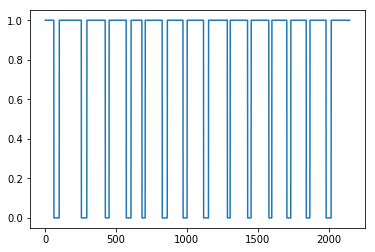

In [9]:
plt.plot(train_validate_label[:,0]);

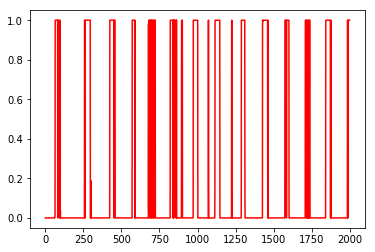

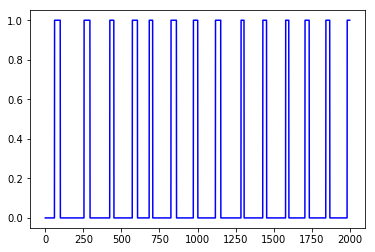

In [10]:
result = sess.run(pred_softmax, feed_dict={x: train_validate})
plt.plot(result[0:2000,1],'r-')
plt.figure()
plt.plot(train_validate_label[0:2000,1],'b-')

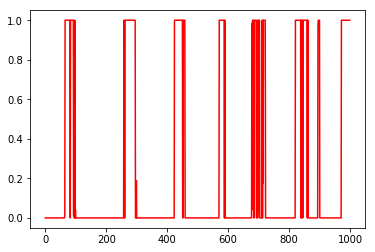

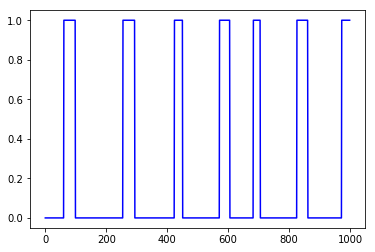

In [12]:
result = sess.run(pred_softmax, feed_dict={x: train_validate})
plt.plot(result[0:1000,1],'r-')
plt.figure()
plt.plot(train_validate_label[0:1000,1],'b-')

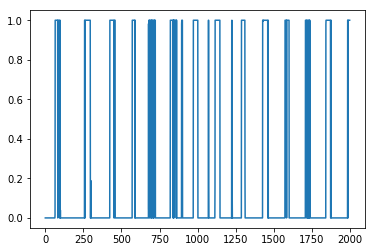

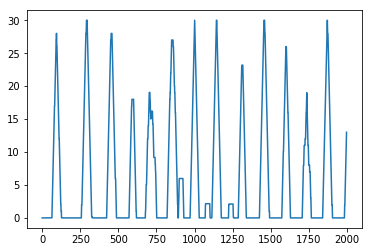

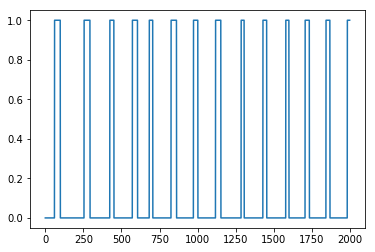

In [13]:
def process_output(raw_result):
    if(raw_result.shape[0] == 1999):
        processed_result = np.zeros(2048)
        #processed_result = raw_result
        for i in range(0,1999):
            processed_result[i:i+30] = processed_result[i:i+30] + 1*raw_result[i]
    else:
        print('input data not valid')
        return None
    return processed_result


raw_result = result[0:0+1999,1]
processed_data = process_output(raw_result)
a= 0
plt.plot(raw_result)
plt.figure()
plt.plot(processed_data[a:1999])
plt.figure()
plt.plot(train_validate_label[a:1999,1])